In [1]:
%matplotlib inline
import numpy as np
import healpy as hp
import matplotlib
import matplotlib.pyplot as plt
import os
from pyuvdata import UVData, UVBeam
from pyuvdata import utils as pyuvutils
import uvtools
import healvis as hv
from itertools import combinations_with_replacement 
import copy
from pathlib import Path
from ruamel.yaml import YAML
import hera_pspec as ps
import glob
import warnings
from hera_cal import io as io
from hera_pspec import PSpecContainer
from hera_pspec import grouping
from hera_cal import frf

#for multiprocessing capability
import concurrent.futures

# for the demo
import CoupledRadioInterferometer as crf
from CoupledRadioInterferometer.Functions import first_order_coupling_functions as FOC
from CoupledRadioInterferometer.Functions import FOC_plotting_funcs as pltFOC

#FONT
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
from CoupledRadioInterferometer.Data import DATA_PATH
from CoupledRadioInterferometer.Beams import BEAM_PATH
from CoupledRadioInterferometer.Instrument_Properties import INSTRUMENT_PATH
from CoupledRadioInterferometer.Sky_Models import SKY_PATH
from CoupledRadioInterferometer.Array_Configurations import ARRAY_CONFIG_PATH
from CoupledRadioInterferometer.YAMLs import YAML_PATH

In [3]:
BEAM_PATH

'/home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Beams'

# Introduction

The following ipynb notebook demonstrates the semi-analyitc, first-order coupling formalism presented in XXX. By following the notebook, you will see how to apply the first-order coupling algorithm to a series of input, noiseless, non-coupled, simulated visibility datasets in uvh5 format. For the results to be meaningful, this algorithm should not be run on real data from an existing interferometric array, unless the data has been heavily filtered to avoid first-order coupling effects already. 

Feel free to input your own simulated data. Should you do so, it may be wise to simulate a diffuse sky and a point-source sky separately, as is done here. As described in the paper, a diffuse sky and a point source sky may exhibit different coupling effects at the same LST, and both datasets will exhibit different coupling effects at different LSTs. 

This algorithm has yet to be run on datasets containing noise. One should carefully consider how the sum terms in the coupling formalism would affect the noisefloor of a zeroth-order visibility dataset. One suggestion - which has not been tested - is to only add noise after running the first-order coupling algorithm, so that the noise floor does not get copied at each sum over zeroth-order visibilities.  

two sample input datasets are provided: a diffuse sky model and a point-source sky model, both of which run from 144-169 MHz, with 250kHz resolution, in an LST range of [23.9-2.4]. This is the dataset used for the 'Galactic Set' figures in the paper, and correspond to the galaxy setting in the western horizon at the location of the HERA array, in the Karoo Radio Astronomy Reserve in South Africa. The healvis configuration file used to make this simulation is provided: '~/YAMLs/healvis_config_full_galactic_set.yaml'

If you choose to apply the first-order coupling algorithm to pre-existing uvh5 visibility datasets, keep the setting 'RUN_NEW_SIM = False' in the simulation control one cell below. 

One can also use this ipynb to simulate new zeroth-order visibility data. Should you choose to do so, change the simulation boolean to 'RUN_NEW_SIM = True' and change the input YAML file in 'HV_YAML_IN'. An example YAML file for a small dataset is provided: ~/YAMLs/healvis_config_demo.yaml'. Note, however, that this demo configuration  has a significantly less precise frequency and time resolution compared to the full galactic dataset. Thus, it will not be as usefull to understanding subtle coupling effects. However, it takes approximately an order of magnitude less time to run compared to the full dataset (tens of minutes compared to seveal hours). 

Both the zeroth-order simulator (healvis) and first-order algorithim require the use of an array element beam (in fits format). We rely on the UVBeam software of pyuvdata to handle such objects. To control which beam is used in the zeroth-order simulator (if you choose to use this demo to simulate your own visibilities), see the 'beam_type' key in the 'beam' dictionary of the 'healvis_config_demo.yaml'. If you use the airy disc beams found in the Beams directory of this repo, then set the 'fov' key of the yaml's 'beam' dictionary to something slightly less than 180 degrees; the boundary conditions of thea airy beam I provided, XXX, doesn't behave partiuclarly well with a visibility simulation of the geographic horizon. This beam is for demonstration purposes only, and is not the full, high-precision, CST-simulated beam which was used in the paper. 

# Inputs Not In YAML File

In [4]:
#SIMULATION CONTROL
RUN_NEW_SIM = True#True #If True, run new hv sim. If False, attempt to load pre-existing data.
RUN_NEW_COUPLING = True#True

SIM_EVENT_STR='_GALACTIC_SET'
STR_TITLE_EVENT_LST='Galactic Set' 

# BASELINE CONTROL
BY_REDUNDANCY=True
REDUNDANCY=1.0 # units [m]
MANUAL_ADD_BLS = False #if you want to manually add baseliens from the 'hv_config' YAML file
BLS_FROM_METADATA =False #if you want to add all baselines found in the metadata of the uvh5 file found in 'METADATA_FILE_PATH'
BLS_MANUAL = []
ARRAY_SPECIFIC_JD = True
ARRAY_JD = 2459122

#METADATA CONTROL (Not intended to be JD specific, but contains the whole array, including outriggers)
METADATA_FILE_PATH = str(DATA_PATH+'/hv_sample_metadata.autos.uvh5')#'/home/atj/Data/2459295/all_auto_data/zen.2459295.31932.sum.autos.uvh5'


#SKY CONTROL, ENSURE NSIDE OF EACH MAP MATCHES SKYPARAM['NSIDE']
GDSM_SKY_TYPE=str(SKY_PATH+'/GDSM_Haslam_dsds_Nside128_144-169MHz_101Nfreqs_ud_grade_power0.hdf5') #make sure this has desired Nside and is in celestial coords
GLEAM_RUBY_SKY_TYPE=str(SKY_PATH+'/GLEAM_v2_Ruby_Nside128_144-169MHz_101Nfreqs.hdf5')

DIFFUSE_STR='GDSM'
POINT_STR = 'GLEAM_RUBY'
COMBINED_SKY_STR = 'GDSM+GLEAM_RUBY'
dict_sky_types={}
dict_sky_types[DIFFUSE_STR]=GDSM_SKY_TYPE
dict_sky_types[POINT_STR]=GLEAM_RUBY_SKY_TYPE

d_sky_titles={}
DIFFUSE_TITLE='Diffuse Model \n De-Sourced De-Striped'
POINT_TITLE = 'Point Source Model \n GLEAM I + Extended Sources'
COMBINED_SKY_TITLE = 'Combined Sky \n Diffuse & Point Source Models'
d_sky_titles[DIFFUSE_STR]=DIFFUSE_TITLE
d_sky_titles[POINT_STR]=POINT_TITLE
d_sky_titles[COMBINED_SKY_STR]=COMBINED_SKY_TITLE

#HEALVIS SIMULATION YAML
HV_YAML_IN = str(YAML_PATH+'/healvis_config_demo.yaml')
HV_YAML_OUT = str(YAML_PATH+'/healvis_config_demo_with_bls.yaml')

#COUPLING CONTROL / YAML SELECTION
BOOL_MAKE_NEW_FIRST_ORDER_COMPONENT = True # calculate V^1 - V^0
COUPLING_YAML_IN = str(YAML_PATH+'/first_order_coupling.yaml')

d_cpl_iter={} #coupling titles mapped to corresponding params in first_order_coupling YAML
d_cpl_iter['No Coupling']={}; d_cpl_iter['No Coupling']['type']='none';
d_cpl_iter['All Baselines']={}; d_cpl_iter['All Baselines']['type']='all';

for cpl_title in d_cpl_iter: #needn't apply to all, but for now it does.
    d_cpl_iter[cpl_title]['ABS']='ABS <= np.inf'

#TIME AXIS SPLITTING
SPLIT_TIME_AXIS=False #If true, will split time axis of data into N_TIME_CHUNKS and plot various figures for each chunk. Useful if time axis long enough that many coupling features observed.
N_TIME_CHUNKS = int(3)

#SET PLOT LIMITS AND DYNAMIC RANGE
STR_CMAP='nipy_spectral'

DICT_LIMITS={}
DICT_LIMITS['delay']=(-1300,1300 ) # [ns] 
DICT_LIMITS['fringe-rate']= (-4., 4.)  # [mHz]

PLOT_RANGE={} # for colorbars
PLOT_RANGE[("fringe-rate", "delay")] =(9.6,12.6) #(8.5,12.5)
PLOT_RANGE[("freq", "time")] =(0,4.5)
PLOT_RANGE[("delay","time")] =(5,10)
PLOT_RANGE[("freq", "fringe-rate")] =(3.5,7)


#ARRAY CONFIG CONTROL - File must be in ARRAY_PATH
ARRAY_FNAME = '/HERA_JD_2459122_demo.csv'

#BEAM CONTROL - Files must be in BEAM_PATH
BEAM_FNAME_HV = '/airy_analytic_power_beam_240_Nfreqs_64_nside_healpix_v2.fits'
BEAM_FNAME_FOC_E = '/airy_analytic_efield_beam_240_Nfreqs_64_nside_healpix_v2.fits'
BEAM_FNAME_FOC_P = 'airy_analytic_power_beam_240_Nfreqs_64_nside_healpix_v2.fits'
BEAM_FNAME_FOC_HH = '/airy_HH_beam_healpix.fits'
BEAM_FNAME_FOC_HdagHdag = '/airy_HdagHdag_beam_healpix.fits'

(350, 3)
(350,)
Shape of ants_to_sim which are present in ARRAY_JD antenna configuration file: (15,)
They are: [176 177 178 179 180 181 182 183 184 185 186 187 189 190 191]


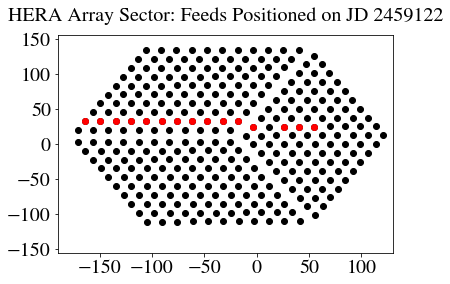

In [5]:
metadata=UVData()
metadata.read(METADATA_FILE_PATH,file_type='uvh5',ant_str='auto',read_data=False,run_check=False,check_extra=False,keep_all_metadata=False)
antpos_metadata, ants_metadata= metadata.get_ENU_antpos()


print(str(np.shape(antpos_metadata)))
print(str(np.shape(ants_metadata)))

plt.plot(antpos_metadata[:,0],antpos_metadata[:,1],'ko')

if ARRAY_SPECIFIC_JD:
    ants_sim_day=np.loadtxt(str(ARRAY_CONFIG_PATH+'/H'+str(ARRAY_JD)+'_demo.txt'), skiprows=2,usecols=(5),dtype='str')
    ants_sim_day=np.unique(np.array([ant[1:] for ant in ants_sim_day]).astype(int)) #remove 'A' prefix from string name of ants, and then only take unique values so as to avoid double-counting due to E and N pols
    ants_to_sim = np.intersect1d(ants_metadata, ants_sim_day)
    print('Shape of ants_to_sim which are present in ARRAY_JD antenna configuration file: '+str(np.shape(ants_to_sim)))
    print('They are: '+str(ants_to_sim))
    ii_to_use = np.where(np.in1d(ants_metadata, ants_to_sim))[0]
    plt.plot(antpos_metadata[:,0][ii_to_use], antpos_metadata[:,1][ii_to_use],marker='o',color='red', linestyle='None')
    plt.ylim((-155,155))
    plt.xlim((-190,130))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title(str("HERA Array Sector: Feeds Positioned on JD "+str(ARRAY_JD)), fontsize=20, pad=15)
    bl_groups, vec_bin_centers, lengths = pyuvutils.get_antenna_redundancies(ants_metadata[ii_to_use], antpos_metadata[ii_to_use], include_autos=True)
    Nants_used = int(np.size(ants_metadata[ii_to_use]))
    if BLS_FROM_METADATA:
        ENU_combinations=np.array(list(combinations_with_replacement(antpos_metadata[ii_to_use], 2))) #combinations with replacement includes autocorrs
        ant_combinations=np.array(list(combinations_with_replacement(ants_metadata[ii_to_use], 2)))
        bls=[]

        for ip, pair in enumerate(ant_combinations): # find all bls combinations
            bls.append((pair[0],pair[1]))
        BLS_MANUAL = bls

# Load Healvis YAML file
also calculate ENU of each unique baseline group usin hv functions

In [6]:
yaml = YAML()
hv_config = yaml.load(Path(HV_YAML_IN))

#Add bls to the 'select' key in the antenna file, because this is JD specific. 
if MANUAL_ADD_BLS:
    hv_config['select']['bls']=str(BLS_MANUAL)
    
elif BY_REDUNDANCY: #REPLACE with bls_unique_ENUs? 
    hv_config['telescope']['redundancy']=REDUNDANCY
    
## Add parameters to the YAML
hv_config['filing']['outdir'] = str(DATA_PATH+'/'+str(ARRAY_JD)+'/')
hv_config['telescope']['array_layout'] = str(ARRAY_CONFIG_PATH+ARRAY_FNAME)
hv_config['beam']['beam_type']=str(BEAM_PATH+BEAM_FNAME_HV)

for key in hv_config:
    if key=='select':
        for subkey in hv_config[key]:
            if subkey!='bls':
                print('hv_config[select]['+str(subkey)+']: '+str(hv_config[key][subkey]) )
            else:
                print('select: ['+str(subkey)+']: Present but not printing. Shape: '+str(np.shape(BLS_MANUAL)))
    else:
        print(str(key)+': '+str(hv_config[key]))
    print('\n')

if hv_config['filing']['clobber']:
    warnings.warn("WARNING, clobber = True . Are you sure you want this?")
    
#PRINT CONTENTS OF THE YAML FILE
yaml.dump(hv_config, Path(HV_YAML_OUT))

Nprocs: 11


Nskies: 1


do_horizon_taper: True


freq: ordereddict([('start_freq', 144000000), ('end_freq', 159000000), ('Nfreqs', 61)])


time: ordereddict([('start_time', 2459122.42), ('end_time', 2459122.48), ('Ntimes', 70)])


filing: ordereddict([('outfile_prefix', 'hv'), ('outdir', '/home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Data/2459122/'), ('clobber', True), ('format', 'uvh5')])


skyparam: ordereddict([('sky_type', None), ('Nside', 128), ('Nskies', 1)])


telescope: ordereddict([('telescope_location', '(-30.72152777777791, 21.428305555555557, 1073.0000000093132)'), ('array_layout', '/home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Array_Configurations/HERA_JD_2459122_demo.csv'), ('telescope_name', 'HERA'), ('redundancy', 1.0)])


beam: ordereddict([('beam_type', '/home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Beams/airy_analytic_power_beam_240_Nfreqs_64

# Run Simulation
 running local version of Github so that two modifications occur: First, so that in beam_models, the simulated beam is once-again automatically peak-normalized. Not sure why that is not option in most-recent 'master' on Github (as of 3 June 2021). Second, in the 'setup_uvdata()' function of the 'simulator.py' script, baselines where element number a1 > a2 are no longer forgotten.
 
Simulating 61 frequencies at 70 times, for two different sky models, using a beam with 120 frequencies and an Nside of 64, on an array configuration with 26 unique baseline groups, on a Linux machine running Ubuntu 20.04 with an Intel Core-i5 104000 processor takes less than 15 minutes and approximately 20 GB of RAM. YAML name: healvis_config_demo.yaml ; the RAM requirement can be significantly reduced by lowering the 'Nprocs' parameter in the YAML.

Using the same machine to simulate the datasets plotted in the paper (230 times, 101 frequencies, on an array configuration with over 700 unique baseline groups), with a beam of the same Nside but many more frequencies, takes substantially longer, several hours. YAML name: healvis_config_full_galactic_set.yaml

In [7]:
RUN_NEW_SIM

True

In [8]:
dict_uvd = {}

In [9]:
for sky in dict_sky_types:
    if sky not in dict_uvd:
        yaml = YAML() #Keep most YAML configs the same, but we do need to change out the skies
        hv_config = yaml.load(Path(HV_YAML_OUT))
        hv_config['filing']['outfile_suffix']=str(str(sky)+'_FOV'+str(hv_config['beam']['fov'])+'_NTIMES'+str(hv_config['time']['Ntimes'])+'_Nbls'+str(np.shape(BLS_MANUAL)[0])+str(SIM_EVENT_STR))
        hv_config['skyparam']['sky_type']=str(dict_sky_types[sky])
        yaml.dump(hv_config, Path(HV_YAML_OUT))

        if RUN_NEW_SIM:
            print('SIMULATING '+str(sky)+' WITH SKY_TYPE: '+str(dict_sky_types[sky])+'\n')
            hv.simulator.run_simulation(HV_YAML_OUT)
        else:
            print(sky+': Not running new simulation. Will attempt to load pre-existing data.')

SIMULATING GDSM WITH SKY_TYPE: /home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Sky_Models/GDSM_Haslam_dsds_Nside128_144-169MHz_101Nfreqs_ud_grade_power0.hdf5

Nprocs:  11
...reading /home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Sky_Models/GDSM_Haslam_dsds_Nside128_144-169MHz_101Nfreqs_ud_grade_power0.hdf5
Nbls: 26
Peak-normalizing the beam
Doing frequency interpolation: nearest
Running simulation
Nskies: 1
Finished: 10, Elapsed 1.01min, Remain 0.101hour, MaxRSS 1.016584GB
Finished: 17, Elapsed 1.83min, Remain 0.095hour, MaxRSS 1.587248GB
Finished: 27, Elapsed 2.62min, Remain 0.070hour, MaxRSS 1.847404GB
Finished: 38, Elapsed 3.50min, Remain 0.049hour, MaxRSS 1.853656GB
Finished: 50, Elapsed 4.42min, Remain 0.029hour, MaxRSS 1.853656GB
Finished: 65, Elapsed 5.38min, Remain 0.007hour, MaxRSS 1.853656GB
Finished: 68, Elapsed 5.97min, Remain 0.003hour, MaxRSS 1.853656GB
...writing /home/atj/anaconda3/envs/rep

# Load zeroth-order visibility data
uvh5 file format

In [10]:
for sky in dict_sky_types:
    print(str(sky))
    str_files=str('*'+str(sky)+'_FOV'+str(hv_config['beam']['fov'])+'*NTIMES'+str(hv_config['time']['Ntimes'])+'*Nbls'+str(np.shape(BLS_MANUAL)[0])+str(SIM_EVENT_STR)+'.uvh5')
    str_path = str(hv_config['filing']['outdir']+str_files)
    print('Loading uvh5 from: '+str_path)
    files=glob.glob((str_path))
    print('    Files to read: '+str(files))
    dict_uvd[sky]=UVData()
    dict_uvd[sky].read(files,file_type='uvh5')
    dict_uvd[sky].integration_time = np.ones(np.shape(dict_uvd[sky].integration_time)) * (np.unique(dict_uvd[sky].time_array)[1]-np.unique(dict_uvd[sky].time_array)[0] )*3600*24
    dict_uvd[sky].write_uvh5(files[0],clobber=True) # write back, so it has correct integration time. A fault of healvis output now being corrected.

#Create uvd object where the visibilities are the sum of GDSM and GLEAM 
if np.logical_and(DIFFUSE_STR in dict_uvd, POINT_STR in dict_uvd):
    dict_uvd[COMBINED_SKY_STR]=dict_uvd[DIFFUSE_STR].sum_vis(dict_uvd[POINT_STR], inplace=False)
    dict_uvd[COMBINED_SKY_STR].integration_time = np.ones(np.shape(dict_uvd[COMBINED_SKY_STR].integration_time)) * (np.unique(dict_uvd[COMBINED_SKY_STR].time_array)[1]-np.unique(dict_uvd[COMBINED_SKY_STR].time_array)[0] )*3600*24

GDSM
Loading uvh5 from: /home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Data/2459122/*GDSM_FOV179*NTIMES70*Nbls0_GALACTIC_SET.uvh5
    Files to read: ['/home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Data/2459122/hv_GDSM_FOV179_NTIMES70_Nbls0_GALACTIC_SET.uvh5']
File exists; clobbering
GLEAM_RUBY
Loading uvh5 from: /home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Data/2459122/*GLEAM_RUBY_FOV179*NTIMES70*Nbls0_GALACTIC_SET.uvh5
    Files to read: ['/home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Data/2459122/hv_GLEAM_RUBY_FOV179_NTIMES70_Nbls0_GALACTIC_SET.uvh5']
File exists; clobbering


Below, we plot various baselines in the zeroth-order visibility dataset(s).

NOTE: if you are using the healvis simulator above to simulate zeroth-order visibilities (rather than inputting your own data), these datasets only have one baseline per unique group. That is, one baseline per unique set of ENU coordinates and orientation. Thus, there is only one 28m E/W baseline, which happens to be (0,2,'xx') due to the ordering convention used by pyuvdata. You will not find, for example (176, 178, 'xx') in this dataset, since it is (to zeroth order) identical to (0, 2, 'xx'). If you want to generate (176, 178, 'xx'), you would have to run the command 'inflate_by_redundancy()' on the UVData object. This is done later.

To control which baselines are plotted, adjust 'keys_to_plot' below, NOT 'keys_out' in the first_order_coupling YAML. This is to avoid issues with baseline redundancy. 

To control which skies are plotted, adjust 'dict_sky_types' in the Non-YAML Controls section

28m E/W Baseline, No Coupling. Pol ['xx']


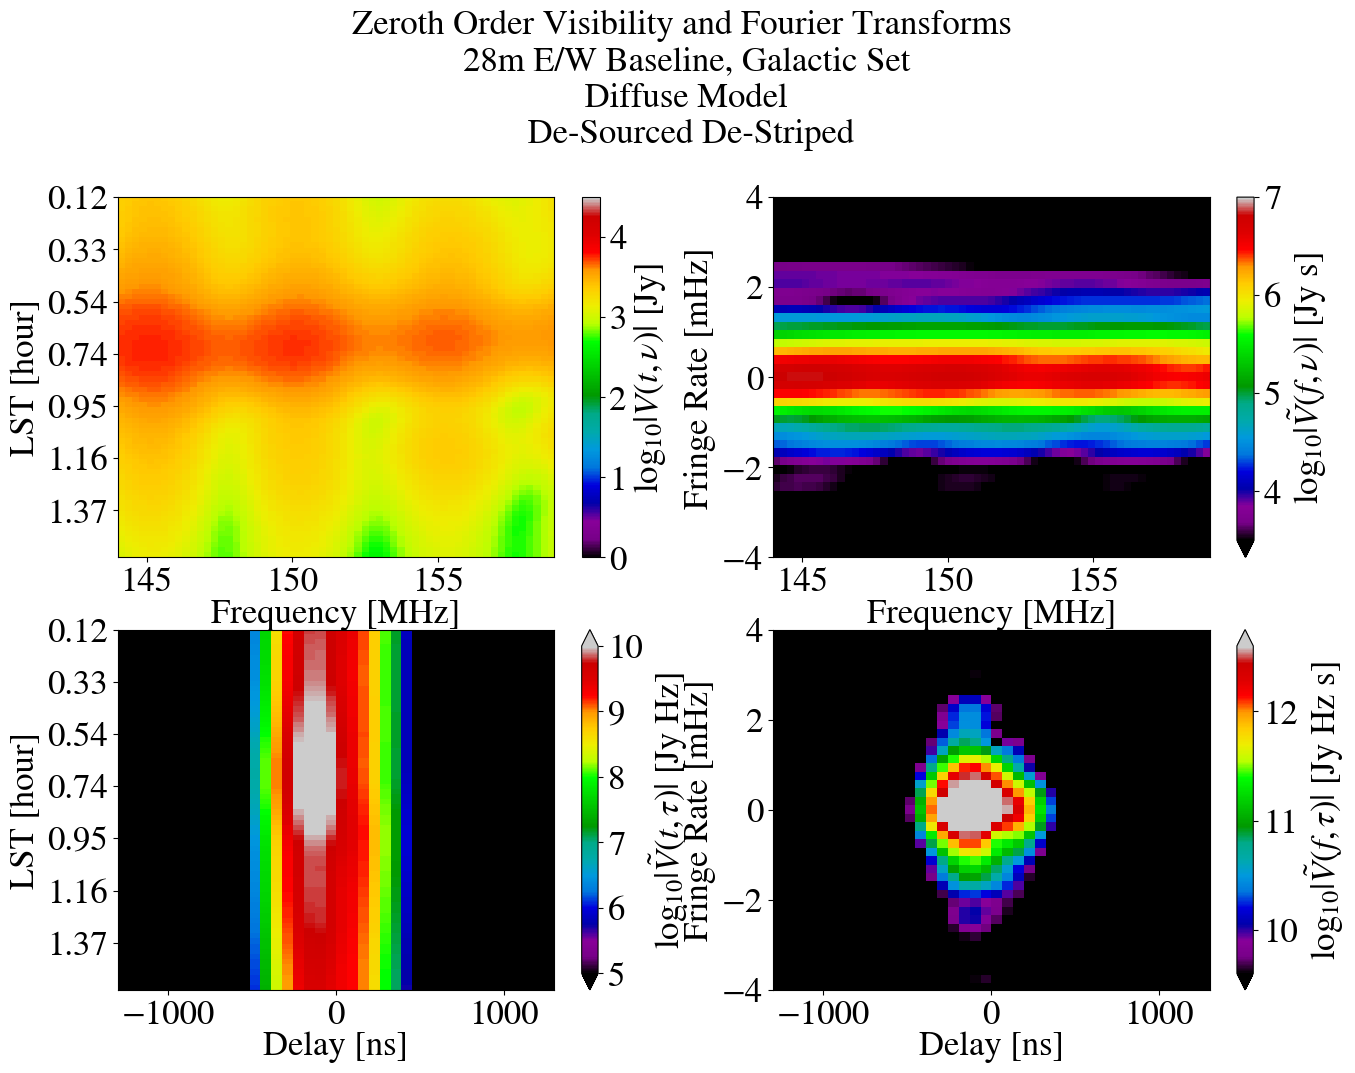

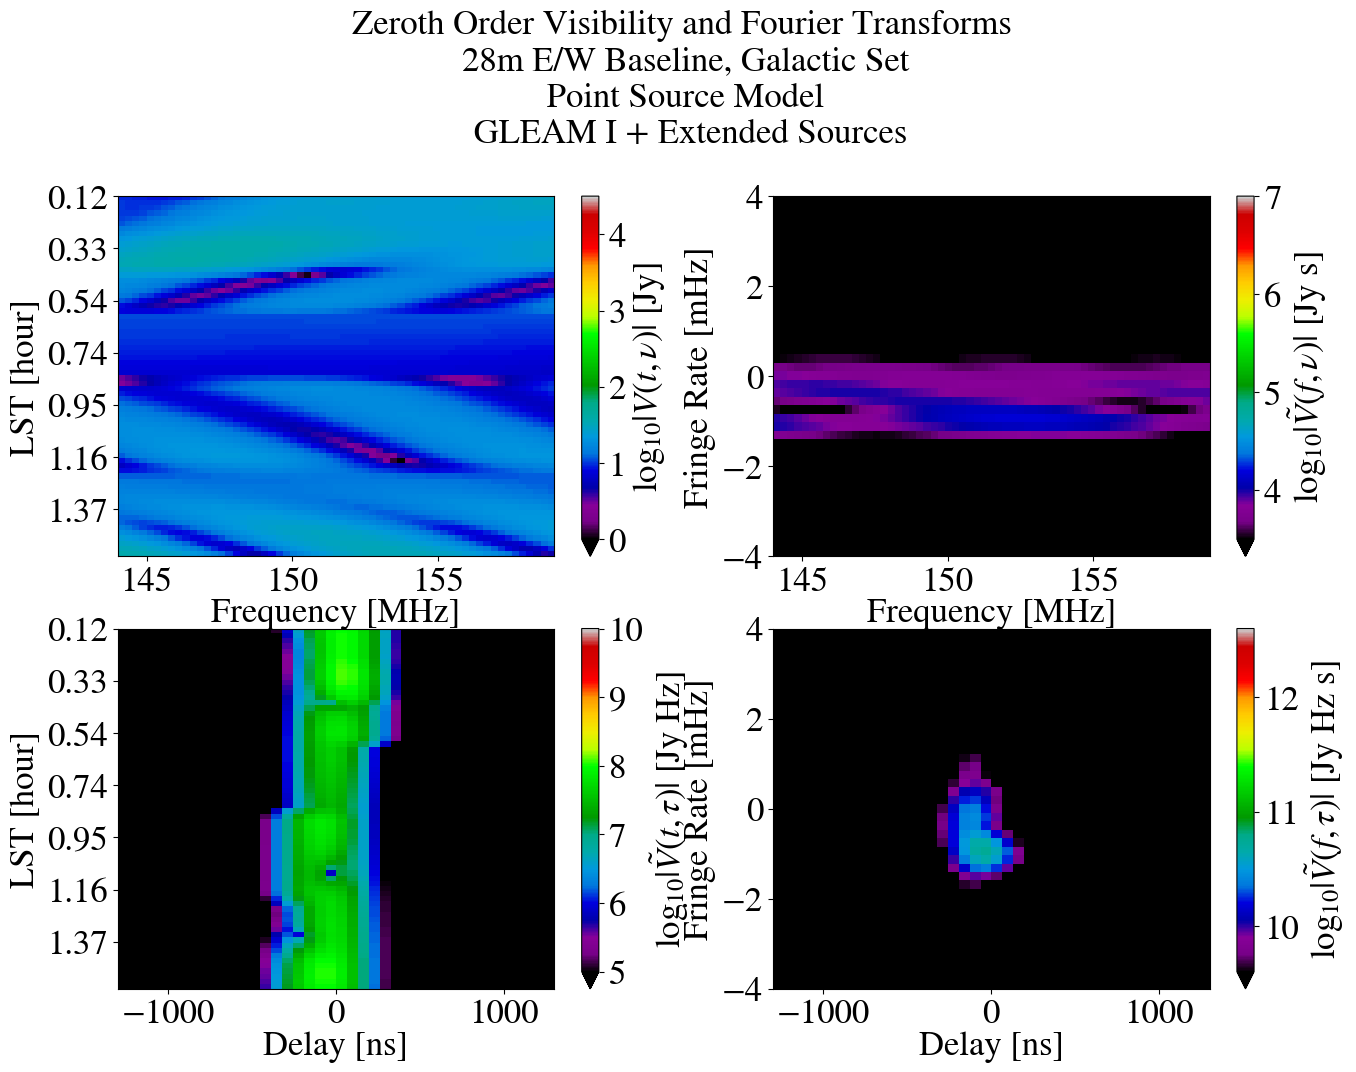

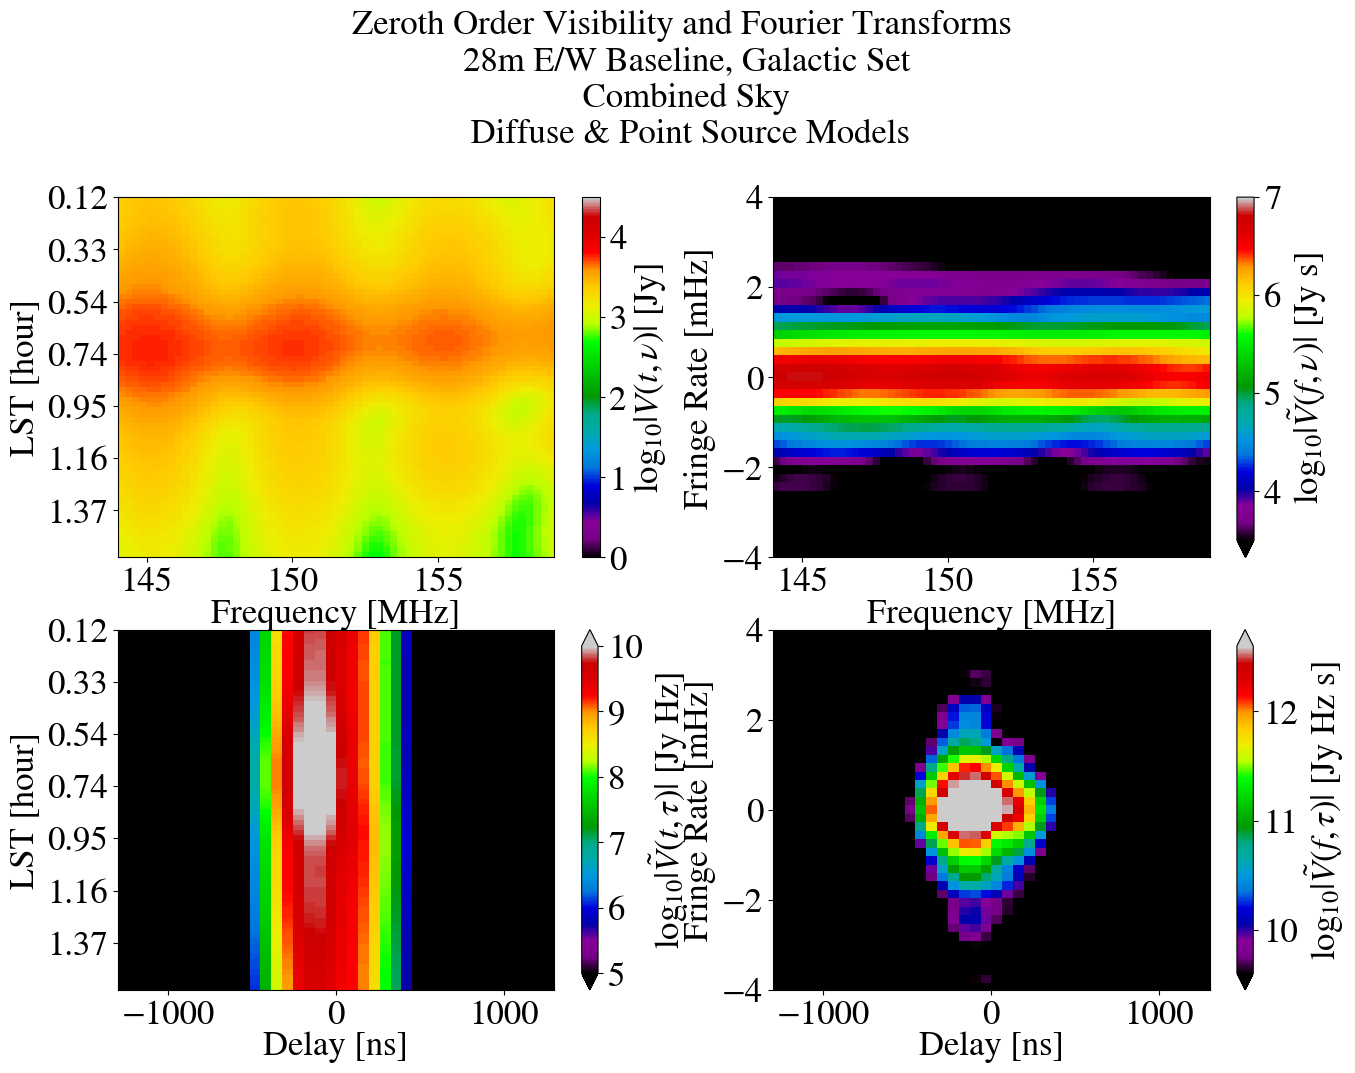

In [11]:
keys_to_plot = [(176, 178, 'xx')] #, (136,156, 'xx')]
key_titles=['28m E/W Baseline'] #,'17m N/S Baseline']

for (key_title, key) in zip(key_titles, keys_to_plot): #dict_uvd[sky].get_antpairpols():
    print(str(key_title)+', No Coupling. Pol '+str(hv_config['beam']['pols']))
    for sky in dict_uvd:
        draw_cbar=True
        title=str('Zeroth Order Visibility and Fourier Transforms \n'+key_title+', '+STR_TITLE_EVENT_LST+'\n '+str(d_sky_titles[sky]))
        #PLOT ALL LSTS
        #if sky == POINT_STR: draw_cbar=True
        fig=uvtools.plot.fourier_transform_waterfalls(dict_uvd[sky],antpairpol=key,freq_taper='bh7',time_taper='bh7',plot_range=PLOT_RANGE,plot_limits=DICT_LIMITS, set_title=title, cmap=STR_CMAP,fontsize=25, tickfontsize=25, figsize=(15.5,10.5))
        if SPLIT_TIME_AXIS:
            #ITERATE OVER DIFFERENT LSTS  
            times_split=np.array_split(np.unique(dict_uvd[sky].time_array), N_TIME_CHUNKS)
            for tChunk in times_split:
                UVD=dict_uvd[sky].select(times=tChunk, inplace=False)
                #PLOT THE DIFFERENT LST SUBSETS
                fig = pltFOC.fourier_transform_waterfalls_2(UVD,antpairpol=key,freq_taper='bh7',time_taper='bh7',plot_range=PLOT_RANGE,plot_limits=DICT_LIMITS, set_title=title, cmap=STR_CMAP, fontsize=55)

# First-Order Coupling
uses the inflate_by_redundancy() command on the input zeroth-order visibilities to go from 1 baseline per group to all baselines per redundant group.

The coupling algorithm currently uses concurrent.futures (https://docs.python.org/3/library/concurrent.futures.html#module-concurrent.futures) to enable multithreading, which saves a significant amount of time. In testing, we notice that we are i/o limited and not cpu limited, and so multithreading saves much more time compared to multiprocessing. if you would like,a single-threaded version is also available in the first_order_coupling_functions, which is called calc_first_order_visibility_uvdata() . This single-threaded versions internally loads the coupled beams. 

The test machine on which this demo was made had 128Gb of RAM. In this configuration, the number of 'max_workers' (threads to process in parallel) was set to 30 when using coupling beams with 100 frequencies. However, if you run this demo on a machine with substantially smaller amounts of RAM, max_workers should be reduced accordingly. The RAM requirements would also reduce if the beam size were smaller. See FOC.XXX

Note, when coupling beams are generated using FOC.make_new_coupling_beams() , the input power beam should not be normalized (just as before), and this time will purposefully not be normalized in order to generate HH and HdaggerHdagger. See Appendix of paper titled 'Compatibility of HERA beam with assumptions in the general formalism'.

The algorithm below could be made significantly faster by storing the coupled beams in shared memory, so all threads have access to the same beam objects.

In [12]:
# PRINT CONTENTS OF THE COUPLING CONFIGURATION FILE
yaml = YAML()
dict_coupling = yaml.load(Path(COUPLING_YAML_IN))

#add parameters
dict_coupling['str_E']=str(BEAM_PATH+BEAM_FNAME_FOC_E)
dict_coupling['str_P']=str(BEAM_PATH+BEAM_FNAME_FOC_P)
dict_coupling['str_HH']=str(BEAM_PATH+BEAM_FNAME_FOC_HH)
dict_coupling['str_HdagHdag']=str(BEAM_PATH+BEAM_FNAME_FOC_HdagHdag)

print('Keys to coupling dict: '+'\n')
for key in dict_coupling:
    print(str(key)+': '+str(dict_coupling[key]))
print('\n')

Keys to coupling dict: 

limit_coupling: ordereddict([('type', 'thresh'), ('E/W', 'np.abs(E) <= np.inf'), ('N/S', 'np.abs(N) <= 7.59'), ('ABS', 'ABS <= np.inf')])
alternate_coupling: ordereddict([('flip_propagator_dir', False), ('sum_both_sigma', False), ('subtr_both_sigma', False), ('flip_sigma_sum', False)])
verbose: False
str_E: /home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Beams/airy_analytic_efield_beam_240_Nfreqs_64_nside_healpix_v2.fits
str_D: /home/atj/Documents/HERA_mutual_coupling_analysis_scripts/CoupledRadioInterferometer/CoupledRadioInterferometer/Beams/airy_analytic_power_beam_240_Nfreqs_64_nside_healpix_v2.fits
str_HH: /home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Beams/airy_HH_beam_healpix.fits
str_HdagHdag: /home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Beams/airy_HdagHdag_beam_healpix.fits
pol: xx
make_new_coupling_beams: True
same_beam_all_freq

In [13]:

if RUN_NEW_COUPLING:
    Vij1s={}
    #LOOP OVER ALL UVDATA OBJECTS
    for sky in dict_uvd: #loop just to get names
        make_coupled_beams = True
        print('\n SKY: '+str(sky))
        str_files=str('*'+str(sky)+'_FOV'+str(hv_config['beam']['fov'])+'*NTIMES'+str(hv_config['time']['Ntimes'])+'*Nbls'+str(np.shape(BLS_MANUAL)[0])+str(SIM_EVENT_STR)+'.uvh5')
        str_path = str(hv_config['filing']['outdir']+str_files)

        files=glob.glob((str_path))

        print('Loading uvh5 from: '+str_path)
        #LOAD zeroth order fresh
        #IF iterating over multiple coupling configs, got to get fresh uvd0, fix this down the road for speed
        if sky !=COMBINED_SKY_STR:
            print('Files to read: '+str(files))
            dict_uvd[sky]=UVData()
            dict_uvd[sky].read(files,file_type='uvh5')

        #Create uvd object where the visibilities are the sum of GDSM and GLEAM 
        if sky == COMBINED_SKY_STR:
            dict_uvd[COMBINED_SKY_STR]=dict_uvd[DIFFUSE_STR].sum_vis(dict_uvd[POINT_STR], inplace=False) #using sum_vis to combine the objects helps to avoid potential conjugation errors


        print('inflating 0th order by redundancy...')
        dict_uvd[sky].inflate_by_redundancy()
        print('done.')

        for cpl_title in d_cpl_iter:
            print('\n  Coupling type: '+str(cpl_title))
            ## Amend the coupling YAML, so we can iterate over different coupling configs
            dict_coupling['limit_coupling']['type']=d_cpl_iter[cpl_title]['type']
            if d_cpl_iter[cpl_title]['type'] == 'thresh':
                dict_coupling['limit_coupling']['E/W']=d_cpl_iter[cpl_title]['E/W']
                dict_coupling['limit_coupling']['N/S']=d_cpl_iter[cpl_title]['N/S']
                dict_coupling['limit_coupling']['ABS']=d_cpl_iter[cpl_title]['ABS']


            print('  copying the zeroth order sky data into new uv data object...')
            uvd1=UVData()
            uvd1=dict_uvd[sky].copy(metadata_only=False)
            print('  Done.')

            print('  loading visibilities from HERAData object...')
            uvd1_dict, uvd1_flags = io.load_vis(uvd1, file_type='uvh5')
            print('  Done. ')

            print('  coupling params: '+str(dict_coupling['limit_coupling']))
            if dict_coupling['limit_coupling']['type']!='none': 
                if dict_coupling['make_new_coupling_beams'] and make_coupled_beams: #Option to make new coupling beams (HH, HdagHdag)
                    uvbHH, uvbHdagHdag = FOC.make_new_coupling_beams(dict_coupling)
                    make_coupled_beams=False
                print('  Performing multithreaded 1st order coupling for '+str(cpl_title)+', '+str(sky)+'...')
                #ADD MULTITHREADED CAPABILITY
                with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor: # Given the ram of this device, 128Gb, should be able to increase max_workers from default of cpu_count + 4 = 12 + 4 = 16. Try 5*cpu_count = 60. Test over 6, then 16, then 60 antpairpols in list (rather than all 10+ thousand) and printing results. 
                    # ^ but, regardless of what max_workers is set to, ThreadPoolExecutor() was significantly faster than ProcessPoolExecutor() for list of 4 antpairpols
                    futures = {executor.submit(FOC.calc_first_order_visibility_uvdata_mt, dict_uvd[sky],dict_coupling, antpairpol): antpairpol for antpairpol in dict_uvd[sky].get_antpairpols()}
                    for future in concurrent.futures.as_completed(futures):

                        try:
                            k, Vij1 = future.result()
                        except Exception as e:
                            print(f"  {futures[future]} throws {e}")
                        else:
                            uvd1_dict[k] = Vij1

                print(' Done.')
            else: print(' Not performing First order coupling, because coupling type is "none".')


            #write to uvh5
            fname_out=str(hv_config['filing']['outdir']+str(sky)+'_FOV'+str(hv_config['beam']['fov'])+'_NTIMES'+str(hv_config['time']['Ntimes'])+'_Nbls'+str(np.shape(BLS_MANUAL)[0])+str(SIM_EVENT_STR)+'_1st_order'+cpl_title+'.uvh5')

            print('  Updating First-Order visibilities and Writing '+str(fname_out) +'\n')
            io.update_vis(uvd1, fname_out, filetype_in='uvh5',filetype_out='uvh5', data=uvd1_dict, clobber=True)
            print('Done.')
            #for antpairpol in dict_coupling['keys_out']:  
            #    fig = pltFOC.fourier_transform_waterfalls_2(dict_uvd[sky],antpairpol=antpairpol,freq_taper='bh7',time_taper='bh7',plot_range=PLOT_RANGE,plot_limits=DICT_LIMITS, set_title=str(str(sky)+', '+cpl_title), cmap=STR_CMAP)



 SKY: GDSM
Loading uvh5 from: /home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Data/2459122/*GDSM_FOV179*NTIMES70*Nbls0_GALACTIC_SET.uvh5
Files to read: ['/home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Data/2459122/hv_GDSM_FOV179_NTIMES70_Nbls0_GALACTIC_SET.uvh5']
inflating 0th order by redundancy...
done.

  Coupling type: No Coupling
  copying the zeroth order sky data into new uv data object...
  Done.
  loading visibilities from HERAData object...
  Done. 
  coupling params: ordereddict([('type', 'none'), ('E/W', 'np.abs(E) <= np.inf'), ('N/S', 'np.abs(N) <= 7.59'), ('ABS', 'ABS <= np.inf')])
 Not performing First order coupling, because coupling type is "none".
  Updating First-Order visibilities and Writing /home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Data/2459122/GDSM_FOV179_NTIMES70_Nbls0_GALACTIC_SET_1st_orderNo Coupling.uvh5

Done.

  Coupling type: All 

In [14]:
dict_uvd_1 = {} #create a dictionary containing all sets of first-order-coupled visibilities
dict_uvd_component = {} # this dictionary contains only the power associated with coupling, e.g. Vij^1 - V_ij^0. See, for example, row 3 of Figure 17 in the paper. 


#containerize first-order visibility data and calculte only the power which is associated with coupling:  V^1 - V^0 
for cpl_title in d_cpl_iter:
    dict_uvd_1[cpl_title]={}
    dict_uvd_component[cpl_title]={}
    for sky in dict_uvd:
            fname_out=str(hv_config['filing']['outdir']+str(sky)+'_FOV'+str(hv_config['beam']['fov'])+'_NTIMES'+str(hv_config['time']['Ntimes'])+'_Nbls'+str(np.shape(BLS_MANUAL)[0])+str(SIM_EVENT_STR)+'_1st_order'+cpl_title+'.uvh5')
            dict_uvd_1[cpl_title][sky]=UVData()
            print('reading '+str(fname_out)+'\n')
            dict_uvd_1[cpl_title][sky].read(fname_out,file_type='uvh5')

            fname_component_out=str(hv_config['filing']['outdir']+str(sky)+'_FOV'+str(hv_config['beam']['fov'])+'_NTIMES'+str(hv_config['time']['Ntimes'])+'_Nbls'+str(np.shape(BLS_MANUAL)[0])+str(SIM_EVENT_STR)+'_1st_order_COMPONENT_ONLY'+cpl_title+'.uvh5')
            if BOOL_MAKE_NEW_FIRST_ORDER_COMPONENT:
                print('Making new first order coupling components (Vij1 - Vij0), and writing to disk')
                dict_uvd[sky].inflate_by_redundancy()
                dict_uvd_component[cpl_title][sky]=dict_uvd_1[cpl_title][sky].diff_vis(dict_uvd[sky],inplace=False)
                dict_uvd_component[cpl_title][sky].write_uvh5(fname_component_out, clobber = True)

            dict_uvd_component[cpl_title][sky]=UVData()
            print('reading '+str(fname_component_out)+'\n')
            dict_uvd_component[cpl_title][sky].read(fname_component_out,file_type='uvh5')


reading /home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Data/2459122/GDSM_FOV179_NTIMES70_Nbls0_GALACTIC_SET_1st_orderNo Coupling.uvh5

Making new first order coupling components (Vij1 - Vij0), and writing to disk
reading /home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Data/2459122/GDSM_FOV179_NTIMES70_Nbls0_GALACTIC_SET_1st_order_COMPONENT_ONLYNo Coupling.uvh5

reading /home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Data/2459122/GLEAM_RUBY_FOV179_NTIMES70_Nbls0_GALACTIC_SET_1st_orderNo Coupling.uvh5

Making new first order coupling components (Vij1 - Vij0), and writing to disk
reading /home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Data/2459122/GLEAM_RUBY_FOV179_NTIMES70_Nbls0_GALACTIC_SET_1st_order_COMPONENT_ONLYNo Coupling.uvh5

reading /home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Da

Plotting First-Order Coupled Visibilites

- To control which baselines are plotted, adjust 'keys_out' in the first_order_coupling YAML

- To control which skies are plotted, adjust 'dict_sky_types' in the Non-YAML Controls section

- To adjust dyanmic range of either the colorbar or fourier windows, see 'plot_range' and 'DICT_LIMITS' in the Non-YAML Controls section

In [15]:
d_fr_tau={}
d_ants_coupled={}
for cpl_title in d_cpl_iter:
        d_fr_tau[cpl_title]={}; d_ants_coupled[cpl_title]={};
        print('  Coupling type: '+str(cpl_title))
        ## Amend the coupling YAML, so we can iterate over different coupling configs
        dict_coupling['limit_coupling']['type']=d_cpl_iter[cpl_title]['type']
        if d_cpl_iter[cpl_title]['type'] == 'thresh':
            dict_coupling['limit_coupling']['E/W']=d_cpl_iter[cpl_title]['E/W']
            dict_coupling['limit_coupling']['N/S']=d_cpl_iter[cpl_title]['N/S']
            dict_coupling['limit_coupling']['ABS']=d_cpl_iter[cpl_title]['ABS']
        d_fr_tau[cpl_title], d_ants_coupled[cpl_title] = FOC.calc_first_order_fringes_and_delays(dict_uvd[sky], dict_coupling)


  Coupling type: No Coupling
    Looping over antpairpols...
    antpairpol (Vij0): (176, 178, 'xx')
    antpairpol (Vij0): (182, 184, 'xx')
    Done.
    In last loop over ants, Ants looped over for k!=i : 0, k!=j : 0
  Coupling type: All Baselines
    Looping over antpairpols...
    antpairpol (Vij0): (176, 178, 'xx')
    antpairpol (Vij0): (182, 184, 'xx')
    Done.
    In last loop over ants, Ants looped over for k!=i : 14, k!=j : 14


In [16]:
#multi-couple, multi-sky plotting.... ax control
multX=1.0
multY=3.5
figsize=(50*multX,10*multY) #good for 1 row, but now multiple rows..
dpi=200

title_antpos='Coupling Configuration \n'

#color=cm.rainbow(np.linspace(0,0.65,len(d_ants_coupled.keys())))
color=plt.get_cmap('brg', len(d_ants_coupled.keys()))

icolor=0 # change per antpairpol

for antpairpol in d_ants_coupled[cpl_title]: #any cpl_title will do.
    print('antpairpol: '+str(antpairpol))

    colorBL=color(icolor)

    fig = plt.figure(figsize=figsize, dpi=dpi) #one fig per ant
    axes = fig.subplots(len(d_cpl_iter),len(d_sky_titles))

    icpl=0
    for cpl_title in d_cpl_iter:
        print('  icpl = '+str(icpl)+', Coupling type: '+str(cpl_title))
        ## Amend the coupling YAML, so we can iterate over different coupling configs
        dict_coupling['limit_coupling']['type']=d_cpl_iter[cpl_title]['type']
        if d_cpl_iter[cpl_title]['type'] == 'thresh':
            dict_coupling['limit_coupling']['E/W']=d_cpl_iter[cpl_title]['E/W']
            dict_coupling['limit_coupling']['N/S']=d_cpl_iter[cpl_title]['N/S']
            dict_coupling['limit_coupling']['ABS']=d_cpl_iter[cpl_title]['ABS']

        isky=0

        #plot the array positions
        print('    isky = '+str(isky))

        #isky+=1
            
        #plot the fringe vs. delay 
        draw_colorbar = True
        for sky in dict_uvd:
            print('    isky = '+str(isky))
            if icpl==0: axes[icpl,isky].set_title(d_sky_titles[sky], fontsize=55)
            remove_colorbar = True
            if isky==2: remove_colorbar=False
            axes[icpl,isky] = pltFOC.plot_fringe_vs_delay(dict_uvd_1[cpl_title][sky],axes[icpl,isky],antpairpol=antpairpol,freq_taper='bh7',time_taper='bh7',plot_range=PLOT_RANGE,plot_limits=DICT_LIMITS, set_title=title, cmap=STR_CMAP, draw_colorbar=draw_colorbar, remove_colorbar=remove_colorbar,cbar_pad = 0.075,fontsize=55,tickfontsize=55,figsize=(12*multX,5*multY))
            if isky==0: axes[icpl,isky].set_ylabel(str(cpl_title+'\n'+axes[icpl,isky].get_ylabel()), fontsize=55)
            isky+=1

        icpl+=1

    icolor+=1
    #TITLE
    set_title=str(STR_TITLE_EVENT_LST+', Baseline Key: ('+str(antpairpol[0])+', '+str(antpairpol[1])+')')
    if set_title is not None:
        # Though complicated, this is the only way I can think of ensuring
        # that the figure title is positioned reasonably and aesthetically.
        axes = fig.get_axes()
        uppermost_y = max(ax.get_position().y1 for ax in axes)
        top_row = [
            ax for ax in axes
            if np.isclose(ax.get_position().y1, uppermost_y)
        ]
        axes_widths = [
            ax.get_position().x1 - ax.get_position().x0
            for ax in top_row
        ]
        colorbars = [
            ax for ax, width in zip(top_row, axes_widths)
            if not np.isclose(width, max(axes_widths))
        ]
        plots = [ax for ax in top_row if ax not in colorbars]
        # Find the visual horizontal center of the figure.
        x1 = min(cbar.get_position().x1 for cbar in colorbars)
        x2 = max(plot.get_position().x0 for plot in plots)
        title_position = (0.5, 1.05*uppermost_y)
        #print('title position X : '+str(0.5 * (x1 + x2))), the orig.
        # Position the title at the apparent "top center" of the figure.
        fig.text(
            *title_position,
            set_title,
            ha="center",
            va="bottom",
            fontsize=75
        )
    #plt.title(STR_TITLE_EVENT_LST,fontsize=75)

antpairpol: (176, 178, 'xx')
  icpl = 0, Coupling type: No Coupling
    isky = 0
    isky = 0
    isky = 1
    isky = 2
  icpl = 1, Coupling type: All Baselines
    isky = 0
    isky = 0
    isky = 1
    isky = 2
antpairpol: (182, 184, 'xx')
  icpl = 0, Coupling type: No Coupling
    isky = 0
    isky = 0
    isky = 1
    isky = 2
  icpl = 1, Coupling type: All Baselines
    isky = 0
    isky = 0
    isky = 1
    isky = 2


# Calculating Zeroth-Order and First-Order Power Spectra
Use the HERA_pspec repository to calculate the power spectrum for a set of interferometric visibilities, input with uvh5 file format. See https://hera-pspec.readthedocs.io/en/latest/uvpspec.html for documentation. The optimal quadratic estimator used to calculate the power spectrum is described in arXiv:1502.06016

If you are running this demo for the first time, all of BOOL_RUN_NEW_PSPEC, BOOL_RUN_NEW_PSPEC_RED_AVG, and BOOL_RUN_NEW_PSPEC_SPH_AVG must be set to true. Once the demo has been run once, you may adjust these parameters accoringly. 

To construct power spectra, we combine information which is redundant both in time and baseline ENU coordinates. Pairs of baselines within each respective redundant baseline group are constructed to estimate a power spectrum. For example, the redundant group of 28m E/W baselines would contain the following pairs: ((176, 178, 'xx'), (176, 178, 'xx')) and ((162, 164, 'xx'), (176, 178, 'xx')).Power spectrum measurements which are constructed using 'auto' baseline pair combinations contain only those combinations of baseline pairs within a redundant group of one pair with itself [e.g. ((176, 178, 'xx'), (176, 178, 'xx'))]. Data sets which are 'cross'-constructed contain all other possible combinations of baseline pairs in the same redundant group, excluding auto baseline pairs [e.g. ((162, 164, 'xx'), (176, 178, 'xx')), but not ((162, 164, 'xx'), (162, 164, 'xx'))]. In this demo, you may choose to calculate the power spectrum using one or both of the above settings. See 'PSPEC_BLP_TYPE'. 

In [17]:
BOOL_RUN_NEW_PSPEC = True # re-calculates the pspec object, using ps.pspecdata.pspec_run(). Time-intensive.
BOOL_RUN_NEW_PSPEC_RED_AVG = True #make a new, redundantly-averaged power spectrum from an input (non-avergaged) power spectrum
BOOL_RUN_NEW_PSPEC_SPH_AVG = True # make a new, spherically averaged power spectrum from an input redundantly-average spectrum
PSPEC_BLP_TYPE = ['auto','cross']  
PSPEC_COMPONENT_TYPE = [''] 
PSPEC_SPH_STATS_WEDGE_SLOPE = 0. # originally, m = 1/0.299
PSPEC_SPH_STATS_WEDGE_DELAY_OFFSET = 1000. # originally, b = 100.
PSPEC_SKY_LIST = ['GDSM+GLEAM_RUBY']
PSPEC_CPL_TITLE_LIST = ['No Coupling', 'All Baselines', '_COMPONENT_ONLYAll Baselines']
BOOL_PSPEC_AUTO_CORRELATIONS_ONLY = False

In [18]:
if BOOL_RUN_NEW_PSPEC:
    print('Running new pspec.')
    # Load beam model
    beamfile = dict_coupling['str_E'] 
    cosmo = ps.conversions.Cosmo_Conversions()
    uvb = ps.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)
    
    if not RUN_NEW_COUPLING: # so that the inflate by redundancy occurs
        print(sky+', inflating 0th order by redundancy...')
        for sky in PSPEC_SKY_LIST:
            dict_uvd[sky].inflate_by_redundancy()
    else:
        print('I am choosing to NOT inlate by redundancy again, so make sure this was done above in the first order coupling calculation.')

    #CHECK INTEGRATION TIME
    for sky in PSPEC_SKY_LIST:
        if np.max(dict_uvd[sky].integration_time) ==0:
            print('WARNING: You are using a uvh5 dataset where the integration_time array is not set. This paramter is required for pspec averages to be correctly calculated. Rewrite the uvh5 file with appropriate integration time. This can be done with commands such as: uvd.integration_time = np.ones(np.shape(uvd.integration_time)) * (np.unique(uvd.time_array)[1]-np.unique(uvd[.time_array)[0] )*3600*24 // uvd.write_uvh5(file,clobber=True)')
            break

    for sky in PSPEC_SKY_LIST:
        print('  Sky: '+str(sky))
        for cpl_title in PSPEC_CPL_TITLE_LIST:
            print('  coupling title: '+str(cpl_title))
            
            for component in PSPEC_COMPONENT_TYPE:
            
                fname=str(hv_config['filing']['outdir']+str(sky)+'_FOV'+str(hv_config['beam']['fov'])+'_NTIMES'+str(hv_config['time']['Ntimes'])+'_Nbls'+str(np.shape(BLS_MANUAL)[0])+str(SIM_EVENT_STR)+'_1st_order'+component+cpl_title+'.uvh5')
                if BOOL_PSPEC_AUTO_CORRELATIONS_ONLY:
                    fname=fname.replace('.uvh5', '.autos.uvh5')


                #TIME AVG DATA TO ~300s
                dsets=[]
                ftavg=fname.replace('.uvh5', '.tavg.uvh5')
                print('    Making ftavg with name: '+str(ftavg))
                frf.time_avg_data_and_write(fname, output_data=ftavg, t_avg=300., rephase=True, clobber=False)
                dsets=[ftavg]
                uvd_ftavg=UVData()
                uvd_ftavg.read(ftavg)
                print('    Minimum integration time (Make sure this is not zero): '+str(np.min(uvd_ftavg.integration_time)))
                for blp in PSPEC_BLP_TYPE: 
                    pspec_kwargs={}
                    if blp =='auto':
                        #NOTE: dsets should have two entries, even if they are the same dataset. Otherwise, it appears that pspec_run does not properly transfer integration_time from dset to integration_array in the UVPspec object. 
                        #or, could have been an overwrite issue, but either way, confirm that uvp.integration_array[0] doesn't have zeros.
                        pspec_kwargs['exclude_cross_bls']=True
                        pspec_kwargs['exclude_auto_bls']=False
                        dsets=[ftavg,ftavg]
                    if blp =='cross':
                        #NOTE: dsets should have two entries, even if they are the same dataset. Otherwise, it appears that pspec_run does not properly transfer integration_time from dset to integration_array in the UVPspec object. 
                        #or, could have been an overwrite issue, but either way, confirm that uvp.integration_array[0] doesn't have zeros.
                        pspec_kwargs['exclude_cross_bls']=False
                        pspec_kwargs['exclude_auto_bls']=True
                        dsets=[ftavg,ftavg]

                    #RUN PSPEC
                    psname = ftavg.replace('.tavg.uvh5', str('.'+blp+'_blps.pspec.h5'))
                    print('    psname: '+str(psname.replace(hv_config['filing']['outdir'],'')))
                    print('    calculating pspec...')
                    ds = ps.pspecdata.pspec_run(dsets=dsets, filename=psname, taper='bh', overwrite=True, verbose=False,store_window=False, store_cov=False, allow_fft=True, Jy2mK=True,beam=uvb,include_autocorrs=BOOL_PSPEC_AUTO_CORRELATIONS_ONLY, include_crosscorrs=bool(not BOOL_PSPEC_AUTO_CORRELATIONS_ONLY),dset_pairs=[(0, 1)], pol_pairs=[(dict_coupling['pol'], dict_coupling['pol'])],file_type='uvh5',**pspec_kwargs)
                    print('    Done.')
else:
    print('NOT running new pspec.')
                
#PSPEC REDUNDANT AVERAGING               
if BOOL_RUN_NEW_PSPEC_RED_AVG:
    print('Creating new redundant averages of pspec...')
    for sky in PSPEC_SKY_LIST:
        for cpl_title in PSPEC_CPL_TITLE_LIST:
            for component in PSPEC_COMPONENT_TYPE:
                fname=str(hv_config['filing']['outdir']+str(sky)+'_FOV'+str(hv_config['beam']['fov'])+'_NTIMES'+str(hv_config['time']['Ntimes'])+'_Nbls'+str(np.shape(BLS_MANUAL)[0])+str(SIM_EVENT_STR)+'_1st_order'+component+cpl_title+'.uvh5')
                if BOOL_PSPEC_AUTO_CORRELATIONS_ONLY:
                    fname=fname.replace('.uvh5', '.autos.uvh5')
                for blp in PSPEC_BLP_TYPE: 
                    psname = fname.replace('.uvh5', str('.'+blp+'_blps.pspec.h5'))
                    print('  psname: '+str(psname.replace(hv_config['filing']['outdir'],'')))

                    #containerize
                    psc = PSpecContainer(psname,keep_open=False, mode='rw')
                    print('    Groups in the PSpecContainer: '+str(psc.groups()))
                    uvp = psc.get_pspec(group='dset0_dset1',psname='dset0_x_dset1') #(group='dset0_dset1', psname='dset0_x_dset1')
                    print('    uvp.integration_array[0][0][0] (should not be zero): '+str(uvp.integration_array[0][0][0]))

                    #calculate redundant blps
                    blp_groups, _, _, _ = ps.utils.get_blvec_reds(uvp, bl_error_tol=1.0)

                    #average the pspec
                    if BOOL_PSPEC_AUTO_CORRELATIONS_ONLY:
                        uvp.average_spectra(blpair_groups=None, time_avg=True)
                    else:
                        uvp.average_spectra(blpair_groups=blp_groups, time_avg=True)
                    psc.set_pspec('dset0_dset1', 'dset0_x_dset1_red_avg', uvp, overwrite=True)
    print('Done.')  
else:
    print('NOT creating new redundant avg of pspec.')


#PSPEC SPHERICAL AVERAGING
if BOOL_RUN_NEW_PSPEC_SPH_AVG: 
    print('Creating new spherical averages of pspec...')
    
    if not RUN_NEW_COUPLING: # so that the inflate by redundancy occurs
        print('  '+sky+', inflating 0th order by redundancy...')
        for sky in PSPEC_SKY_LIST:
            dict_uvd[sky].inflate_by_redundancy()
    else:
        print('  I am choosing to NOT inlate by redundancy again, so make sure this was done above in the first order coupling calculation.')

    
    for sky in PSPEC_SKY_LIST:
        for cpl_title in PSPEC_CPL_TITLE_LIST:
            for component in PSPEC_COMPONENT_TYPE:
                fname=str(hv_config['filing']['outdir']+str(sky)+'_FOV'+str(hv_config['beam']['fov'])+'_NTIMES'+str(hv_config['time']['Ntimes'])+'_Nbls'+str(np.shape(BLS_MANUAL)[0])+str(SIM_EVENT_STR)+'_1st_order'+component+cpl_title+'.uvh5')
                if BOOL_PSPEC_AUTO_CORRELATIONS_ONLY:
                    fname=fname.replace('.uvh5', '.autos.uvh5')
                for blp in PSPEC_BLP_TYPE: 
                    psname = fname.replace('.uvh5', str('.'+blp+'_blps.pspec.h5'))
                    print('  psname: '+str(psname.replace(hv_config['filing']['outdir'],'')))

                    #containerize
                    psc = PSpecContainer(psname,keep_open=False, mode='rw')
                    uvp = psc.get_pspec(group='dset0_dset1',psname='dset0_x_dset1_red_avg')

                    kparas = uvp.get_kparas(0)
                    nk = len(kparas)
                    kbins =  kparas[nk // 2:] # since I've folded, only take the 2nd half of the array
                    dk = np.mean(np.diff(kbins))
                    kwidths = np.ones_like(kbins) * dk

                    uniform_stats_noise = {'P_N':{0: dict_uvd[sky].nsample_array[:,0,:,:]}}
                    uvp.stats_array = copy.deepcopy(uniform_stats_noise)

                    #calculate the spherical avg
                    uvp.set_stats_slice('P_N', m=PSPEC_SPH_STATS_WEDGE_SLOPE, b=PSPEC_SPH_STATS_WEDGE_DELAY_OFFSET, above=False, val=1e20) 
                    uvp = grouping.spherical_average(uvp, kbins=kbins, bin_widths=kwidths, error_weights='P_N')
                    psc.set_pspec('dset0_dset1', 'dset0_x_dset1_sph_avg', uvp, overwrite=True)
    print('Done.')
else:
    print('NOT creating new spherical avg of pspec.')

Running new pspec.
I am choosing to NOT inlate by redundancy again, so make sure this was done above in the first order coupling calculation.
  Sky: GDSM+GLEAM_RUBY
  coupling title: No Coupling
    Making ftavg with name: /home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Data/2459122/GDSM+GLEAM_RUBY_FOV179_NTIMES70_Nbls0_GALACTIC_SET_1st_orderNo Coupling.tavg.uvh5
The t_avg provided of 300.000 has been shifted to 300.522 to make Navg = 4


...writing to /home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Data/2459122/GDSM+GLEAM_RUBY_FOV179_NTIMES70_Nbls0_GALACTIC_SET_1st_orderNo Coupling.tavg.uvh5
    Minimum integration time (Make sure this is not zero): 75.13043135404587
    psname: GDSM+GLEAM_RUBY_FOV179_NTIMES70_Nbls0_GALACTIC_SET_1st_orderNo Coupling.auto_blps.pspec.h5
    calculating pspec...
    Done.
    psname: GDSM+GLEAM_RUBY_FOV179_NTIMES70_Nbls0_GALACTIC_SET_1st_orderNo Coupling.cross_blps.pspec.h5
    calculating pspec...
    Done.
  coupling title: All Baselines
    Making ftavg with name: /home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Data/2459122/GDSM+GLEAM_RUBY_FOV179_NTIMES70_Nbls0_GALACTIC_SET_1st_orderAll Baselines.tavg.uvh5
The t_avg provided of 300.000 has been shifted to 300.522 to make Navg = 4


...writing to /home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Data/2459122/GDSM+GLEAM_RUBY_FOV179_NTIMES70_Nbls0_GALACTIC_SET_1st_orderAll Baselines.tavg.uvh5
    Minimum integration time (Make sure this is not zero): 75.13043135404587
    psname: GDSM+GLEAM_RUBY_FOV179_NTIMES70_Nbls0_GALACTIC_SET_1st_orderAll Baselines.auto_blps.pspec.h5
    calculating pspec...


    Done.
    psname: GDSM+GLEAM_RUBY_FOV179_NTIMES70_Nbls0_GALACTIC_SET_1st_orderAll Baselines.cross_blps.pspec.h5
    calculating pspec...
    Done.
  coupling title: _COMPONENT_ONLYAll Baselines
    Making ftavg with name: /home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Data/2459122/GDSM+GLEAM_RUBY_FOV179_NTIMES70_Nbls0_GALACTIC_SET_1st_order_COMPONENT_ONLYAll Baselines.tavg.uvh5
The t_avg provided of 300.000 has been shifted to 300.522 to make Navg = 4


...writing to /home/atj/anaconda3/envs/repoCRF/lib/python3.9/site-packages/CoupledRadioInterferometer/Data/2459122/GDSM+GLEAM_RUBY_FOV179_NTIMES70_Nbls0_GALACTIC_SET_1st_order_COMPONENT_ONLYAll Baselines.tavg.uvh5
    Minimum integration time (Make sure this is not zero): 75.13043135404587
    psname: GDSM+GLEAM_RUBY_FOV179_NTIMES70_Nbls0_GALACTIC_SET_1st_order_COMPONENT_ONLYAll Baselines.auto_blps.pspec.h5
    calculating pspec...
    Done.
    psname: GDSM+GLEAM_RUBY_FOV179_NTIMES70_Nbls0_GALACTIC_SET_1st_order_COMPONENT_ONLYAll Baselines.cross_blps.pspec.h5
    calculating pspec...
    Done.
Creating new redundant averages of pspec...
  psname: GDSM+GLEAM_RUBY_FOV179_NTIMES70_Nbls0_GALACTIC_SET_1st_orderNo Coupling.auto_blps.pspec.h5
    Groups in the PSpecContainer: ['dset0_dset1']
    uvp.integration_array[0][0][0] (should not be zero): 300.5217254161835
  psname: GDSM+GLEAM_RUBY_FOV179_NTIMES70_Nbls0_GALACTIC_SET_1st_orderNo Coupling.cross_blps.pspec.h5
    Groups in the PSpecCon

Plotting power spectra

Making PSPEC plots...
  psname: GDSM+GLEAM_RUBY_FOV179_NTIMES70_Nbls0_GALACTIC_SET_1st_orderNo Coupling.auto_blps.pspec.h5
    Available groups in the pspec container: ['dset0_x_dset1', 'dset0_x_dset1_red_avg', 'dset0_x_dset1_sph_avg']
    Redundant average analysis...
  psname: GDSM+GLEAM_RUBY_FOV179_NTIMES70_Nbls0_GALACTIC_SET_1st_orderNo Coupling.cross_blps.pspec.h5
    Available groups in the pspec container: ['dset0_x_dset1', 'dset0_x_dset1_red_avg', 'dset0_x_dset1_sph_avg']
    Redundant average analysis...
  psname: GDSM+GLEAM_RUBY_FOV179_NTIMES70_Nbls0_GALACTIC_SET_1st_orderAll Baselines.auto_blps.pspec.h5
    Available groups in the pspec container: ['dset0_x_dset1', 'dset0_x_dset1_red_avg', 'dset0_x_dset1_sph_avg']
    Redundant average analysis...
  psname: GDSM+GLEAM_RUBY_FOV179_NTIMES70_Nbls0_GALACTIC_SET_1st_orderAll Baselines.cross_blps.pspec.h5
    Available groups in the pspec container: ['dset0_x_dset1', 'dset0_x_dset1_red_avg', 'dset0_x_dset1_sph_avg']
    Redundant 

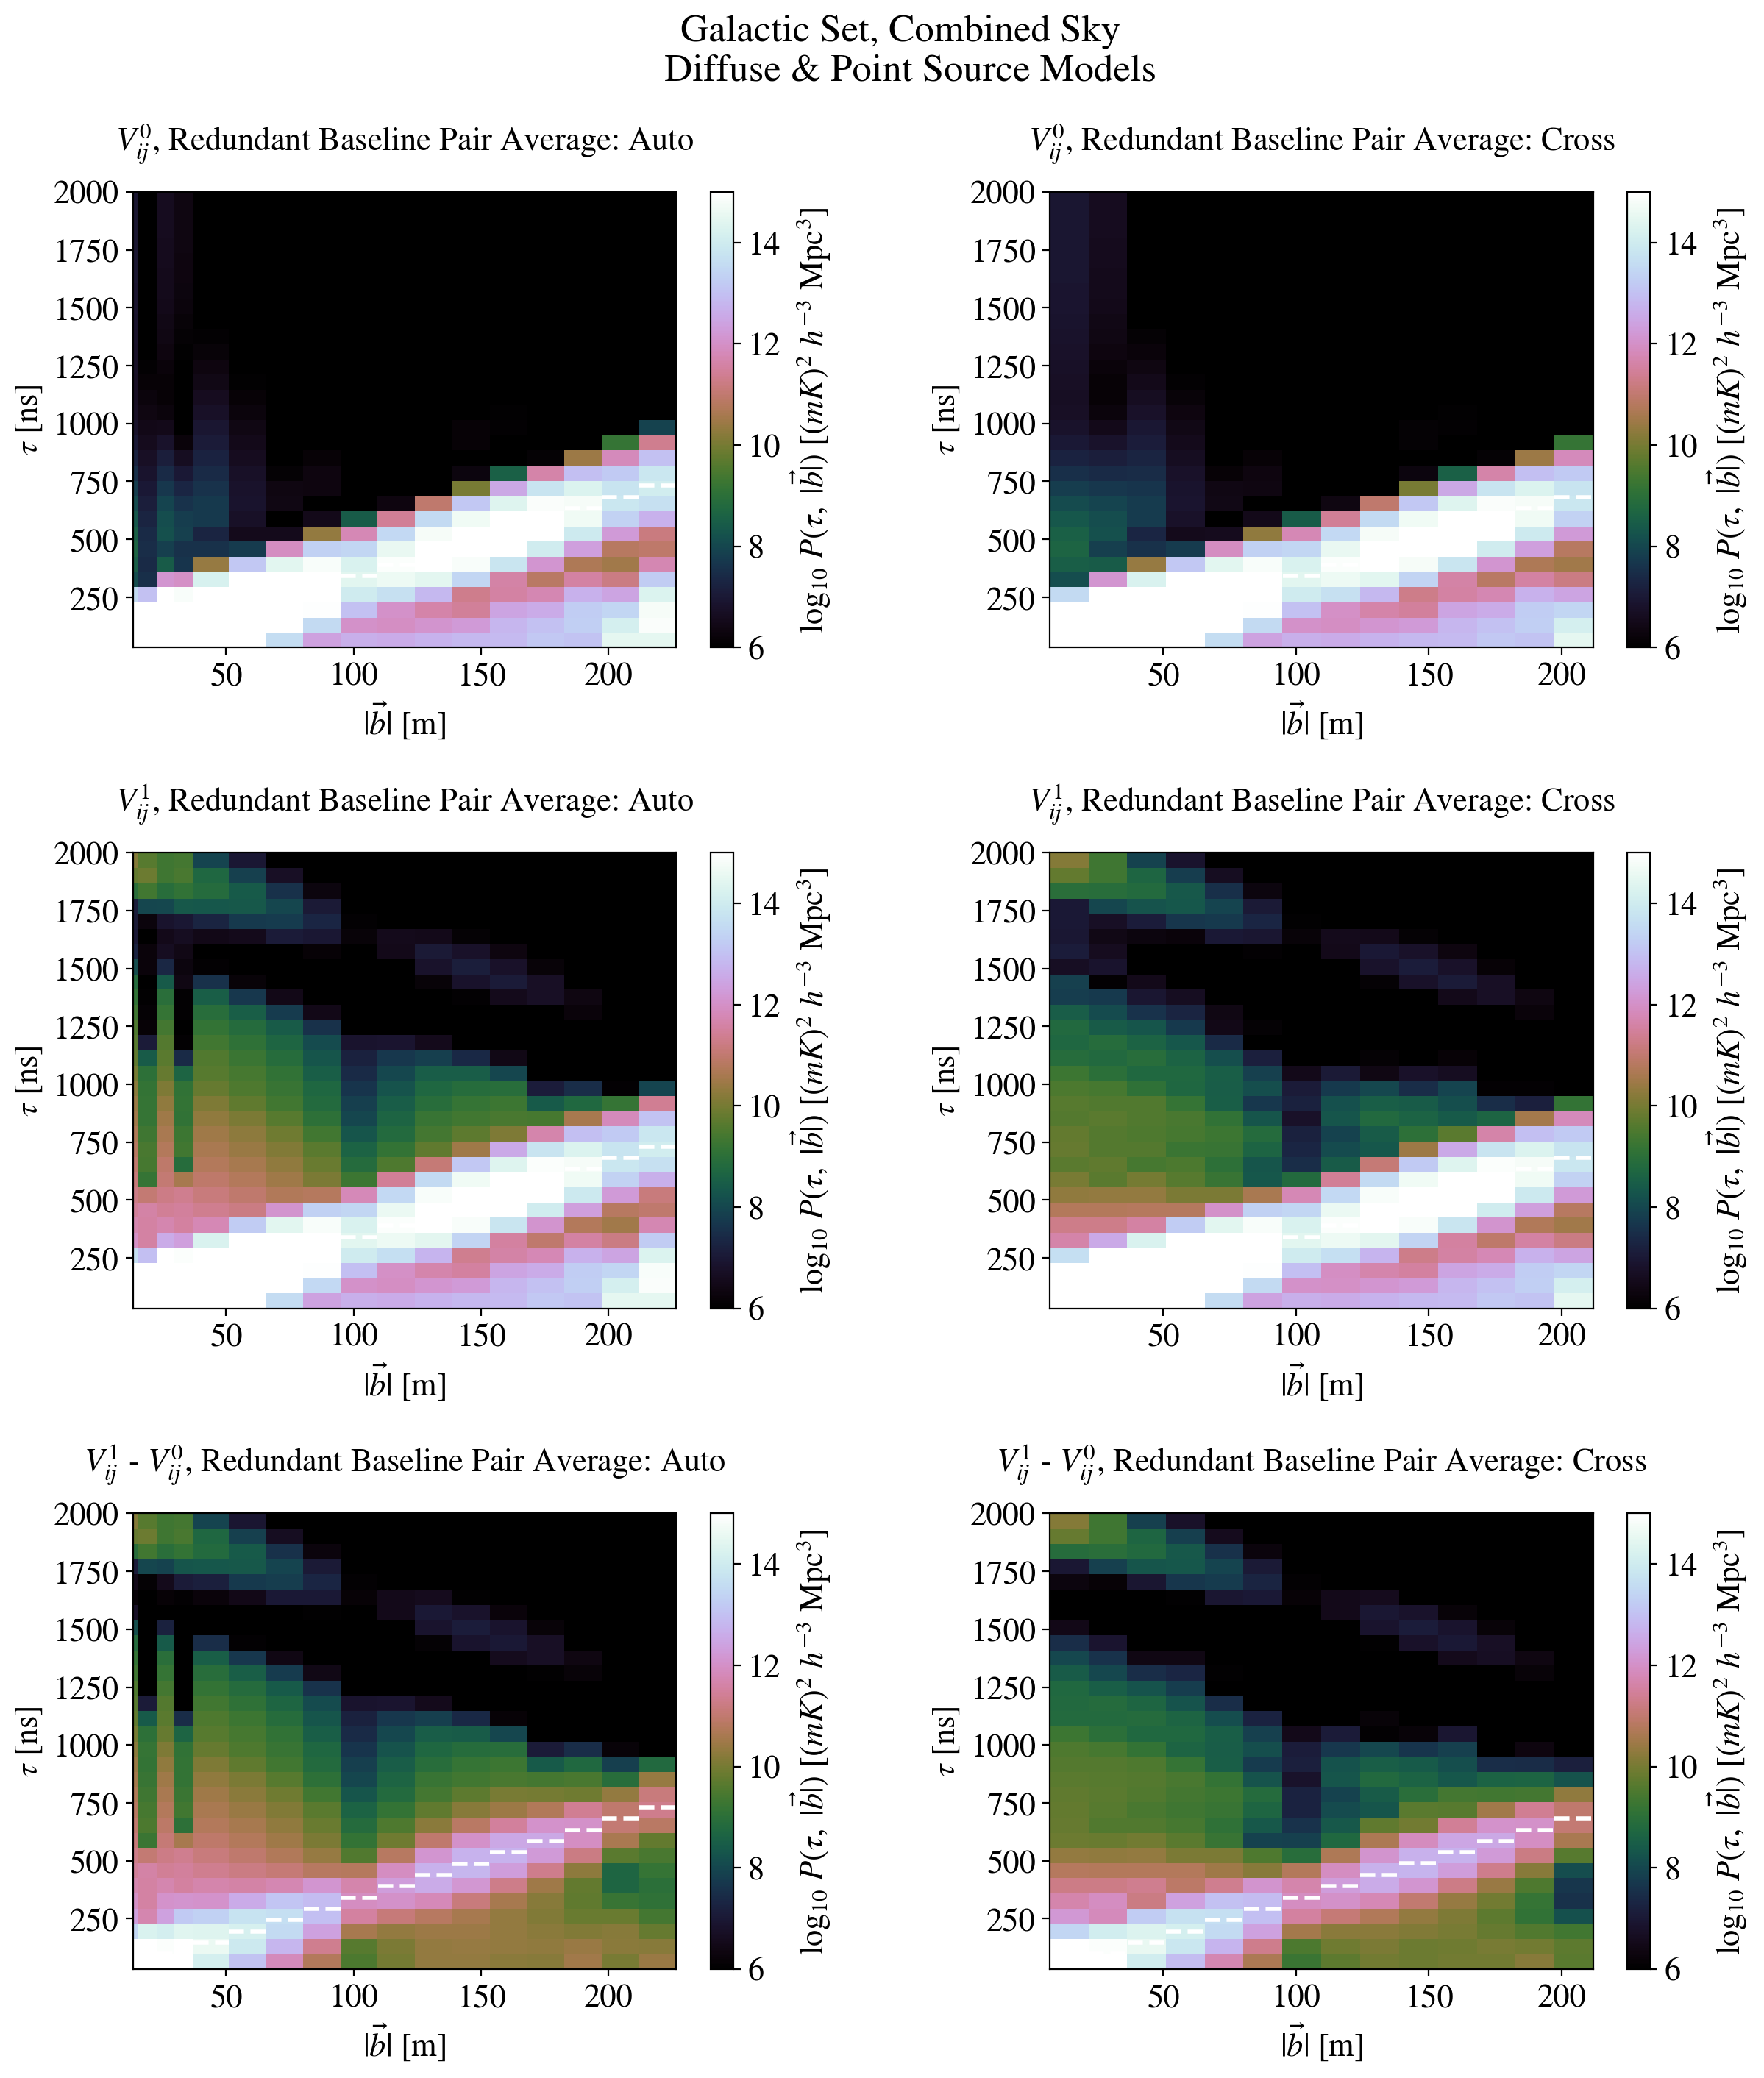

In [19]:
#MAKING PLOTS OF THE POWER SPECTRA

print('Making PSPEC plots...')

# PLOTS FOR AUTO-CORRELATIONS (REGARDLESS OF IF BLP PAIR IS AUTO OR CROSS)
if BOOL_PSPEC_AUTO_CORRELATIONS_ONLY:
    for sky in PSPEC_SKY_LIST:
            fig = plt.figure(figsize=(14,16), dpi=200) #one fig per sky
            fig.tight_layout
            axes = fig.subplots(len(PSPEC_CPL_TITLE_LIST),len(PSPEC_BLP_TYPE))
            icpl=int(0)

            str_coupling_order=''
            str_blp=''
            for cpl_title in PSPEC_CPL_TITLE_LIST:
                fname=str(hv_config['filing']['outdir']+str(sky)+'_FOV'+str(hv_config['beam']['fov'])+'_NTIMES'+str(hv_config['time']['Ntimes'])+'_Nbls'+str(np.shape(BLS_MANUAL)[0])+str(SIM_EVENT_STR)+'_1st_order'+cpl_title+'.uvh5')

                if cpl_title == 'No Coupling': str_coupling_order = '$V^0_{ij}$'
                elif cpl_title == 'All Baselines': str_coupling_order = '$V^1_{ij}$'
                elif cpl_title == '_COMPONENT_ONLYAll Baselines': str_coupling_order = '$V^1_{ij}$ - $V^0_{ij}$'


                if BOOL_PSPEC_AUTO_CORRELATIONS_ONLY:
                    fname=fname.replace('.uvh5', '.autos.uvh5')
                    str_coupling_order += ' Auto Correlations Only'
                iblp=int(0)
                for blp in PSPEC_BLP_TYPE: 
                    if blp == 'auto': str_blp ='\n Redundant Baseline Pair Average: Auto'
                    if blp == 'cross': str_blp ='\n Redundant Baseline Pair Average: Cross'

                    psname = fname.replace('.uvh5', str('.'+blp+'_blps.pspec.h5'))
                    print('  psname: '+str(psname.replace(hv_config['filing']['outdir'],'')))
                    psc = PSpecContainer(psname,keep_open=False, mode='rw')
                    print('    Available groups in the pspec container: '+str(psc.spectra(psc.groups()[0])))

                    # REDUNDANT AVG ANALYSIS
                    print('    Redundant average analysis...')
                    uvp = psc.get_pspec(group='dset0_dset1',psname='dset0_x_dset1_red_avg') 

                    #    wedge plot
                    xtick_size=16
                    ytick_size=16
                    cbar_label_size=16
                    cbar_title_size=16
                    cbar_tick_size=16
                    title_size=16
                    xlabel_size=16
                    ylabel_size=16

                    subplot_title=str(str_coupling_order+', '+str_blp)
                    axes[icpl,iblp].set_title(subplot_title, fontsize=title_size, pad=20)
                    axes[icpl,iblp].set_ylim((1e1,1e20))
                    axes[icpl,iblp].tick_params(axis = 'both', which = 'major', labelsize = xtick_size)
                    axes[icpl,iblp]=ps.plot.delay_spectrum(uvp, spw=0, pol=('xx', 'xx'), ax=axes[icpl,iblp],force_plot=True,fold=True, delay=True, blpairs=list(uvp.blpair_array),component='abs')
                    plt.subplots_adjust(wspace=0.35,hspace=0.5)

                    iblp+=1
                icpl+=1

            #title
            set_title=str(STR_TITLE_EVENT_LST+', '+d_sky_titles[sky])
            if set_title is not None:
                # Though complicated, this ensures that the figure title is reasonably positioned.
                axes = fig.get_axes()
                uppermost_y = max(ax.get_position().y1 for ax in axes)
                top_row = [
                    ax for ax in axes
                    if np.isclose(ax.get_position().y1, uppermost_y)
                ]
                axes_widths = [
                    ax.get_position().x1 - ax.get_position().x0
                    for ax in top_row
                ]

                plots = [ax for ax in top_row]# if ax not in colorbars]
                # Find the visual horizontal center of the figure.
                x1 = min(plot.get_position().x1 for plot in plots)
                x2 = max(plot.get_position().x0 for plot in plots)
                title_position = (0.5, 1.06*uppermost_y)

                # Position the title at the apparent "top center" of the figure.
                fig.text(
                    *title_position,
                    set_title,
                    ha="center",
                    va="bottom",
                    fontsize=19
                )
            print('    Done.')

                
    
# PLOTS FOR CROSS-CORRELATIONS (REGARDLESS OF IF BLP PAIR IS AUTO OR CROSS)
else:
    for sky in PSPEC_SKY_LIST:
            fig = plt.figure(figsize=(14,16), dpi=200) #one fig per sky
            fig.tight_layout
            axes = fig.subplots(len(PSPEC_CPL_TITLE_LIST),len(PSPEC_BLP_TYPE))
            icpl=int(0)

            str_coupling_order=''
            str_blp=''
            for cpl_title in PSPEC_CPL_TITLE_LIST:
                fname=str(hv_config['filing']['outdir']+str(sky)+'_FOV'+str(hv_config['beam']['fov'])+'_NTIMES'+str(hv_config['time']['Ntimes'])+'_Nbls'+str(np.shape(BLS_MANUAL)[0])+str(SIM_EVENT_STR)+'_1st_order'+cpl_title+'.uvh5')

                if cpl_title == 'No Coupling': str_coupling_order = '$V^0_{ij}$'
                elif cpl_title == 'All Baselines': str_coupling_order = '$V^1_{ij}$'
                elif cpl_title == '_COMPONENT_ONLYAll Baselines': str_coupling_order = '$V^1_{ij}$ - $V^0_{ij}$'

                iblp=int(0)
                for blp in PSPEC_BLP_TYPE: 
                    if blp == 'auto': str_blp ='Redundant Baseline Pair Average: Auto'
                    if blp == 'cross': str_blp ='Redundant Baseline Pair Average: Cross'

                    psname = fname.replace('.uvh5', str('.'+blp+'_blps.pspec.h5'))
                    print('  psname: '+str(psname.replace(hv_config['filing']['outdir'],'')))
                    psc = PSpecContainer(psname,keep_open=False, mode='rw')
                    print('    Available groups in the pspec container: '+str(psc.spectra(psc.groups()[0])))

                    # REDUNDANT AVG ANALYSIS
                    print('    Redundant average analysis...')
                    uvp = psc.get_pspec(group='dset0_dset1',psname='dset0_x_dset1_red_avg') 
                    #print('    blpair blvecs: '+str(uvp.get_blpair_blvecs()))
                    #    wedge plot
                    xtick_size=16
                    ytick_size=16
                    cbar_label_size=16
                    cbar_title_size=16
                    cbar_tick_size=16
                    title_size=16
                    xlabel_size=16
                    ylabel_size=16

                    subplot_title=str(str_coupling_order+', '+str_blp)
                    axes[icpl,iblp].set_title(subplot_title, fontsize=title_size, pad=20)
                    axes[icpl,iblp]=pltFOC.delay_wedge(uvp, spw=0, pol=('xx', 'xx'), ax=axes[icpl,iblp],fold=True, delay=True, rotate=True,vmin=6, vmax=15, colorbar=True, horizon_lines=True, xtick_size=xtick_size, ytick_size=ytick_size,cbar_label_size=cbar_label_size,cbar_title_size=cbar_title_size,title_size=title_size,xlabel_size=xlabel_size,ylabel_size=ylabel_size,cbar_tick_size=cbar_tick_size,cmap='cubehelix')#,title=subplot_title)
                    plt.subplots_adjust(wspace=0.35,hspace=0.45)

                    iblp+=1
                icpl+=1

            #title
            set_title=str(STR_TITLE_EVENT_LST+', '+d_sky_titles[sky])
            if set_title is not None:
                # Though complicated, this is the only way I can think of ensuring
                # that the figure title is positioned reasonably and aesthetically.
                axes = fig.get_axes()
                uppermost_y = max(ax.get_position().y1 for ax in axes)
                top_row = [
                    ax for ax in axes
                    if np.isclose(ax.get_position().y1, uppermost_y)
                ]
                axes_widths = [
                    ax.get_position().x1 - ax.get_position().x0
                    for ax in top_row
                ]
                colorbars = [
                    ax for ax, width in zip(top_row, axes_widths)
                    if not np.isclose(width, max(axes_widths))
                ]
                plots = [ax for ax in top_row if ax not in colorbars]
                # Find the visual horizontal center of the figure.
                x1 = min(cbar.get_position().x1 for cbar in colorbars)
                x2 = max(plot.get_position().x0 for plot in plots)
                title_position = (0.5, 1.05*uppermost_y)
                # Position the title at the apparent "top center" of the figure.
                fig.text(
                    *title_position,
                    set_title,
                    ha="center",
                    va="bottom",
                    fontsize=19
                )
            print('    Done.')
                
print('Done.')